# ABM


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.1 MB/s eta 0:00:00

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 40, 3, 1, 5)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (40, 3, 1, 5)


Initializing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/121 [00:00<?, ?it/s]

Total execution time: 0.50s


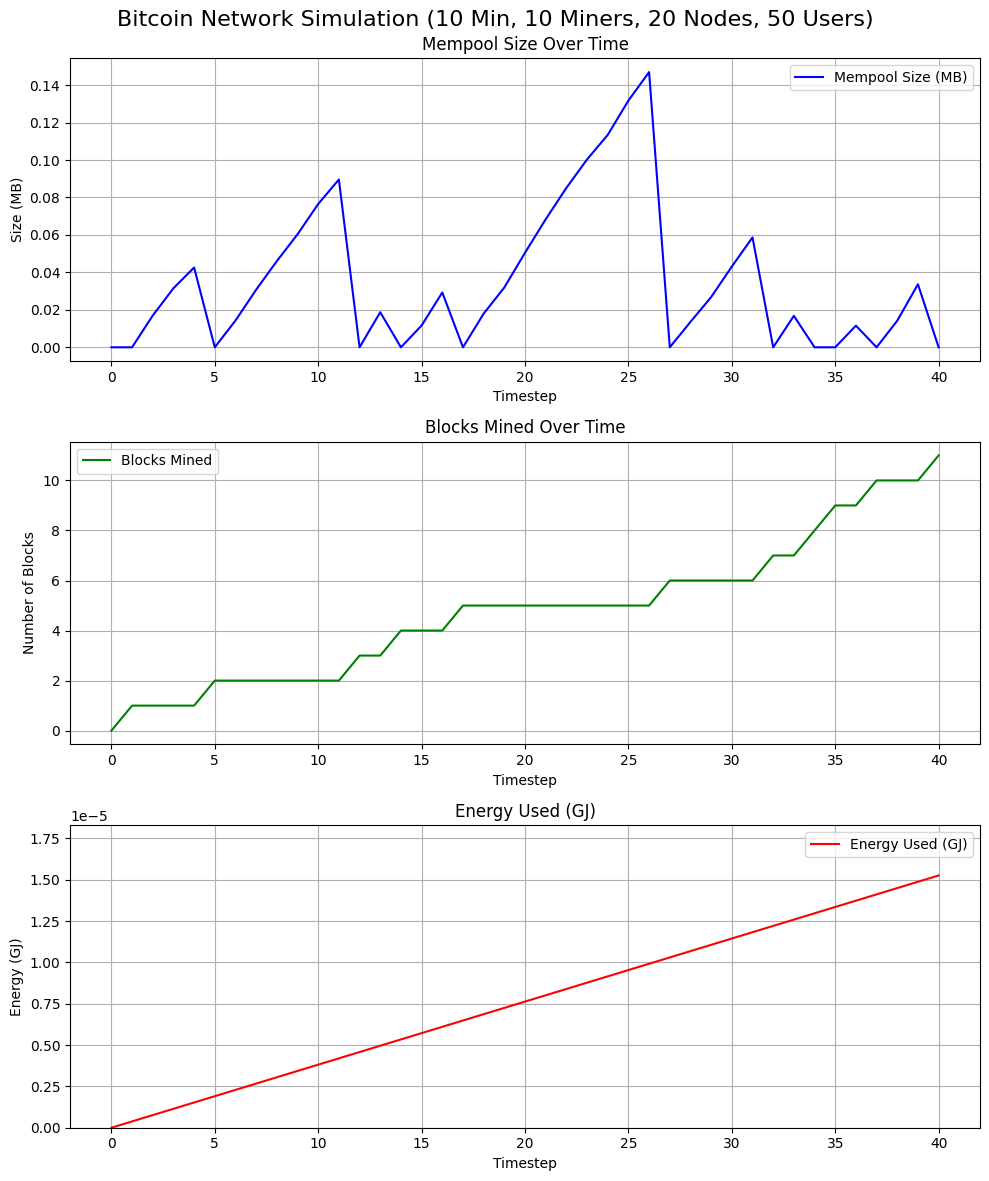

Total blocks mined: 11
Total transactions processed: 907
Average transactions per block: 82.45
Transaction Throughput: 5442.00 tx/hour
Final Mempool Size: 0.00 MB
Energy Used: 0.00 GJ


In [1]:
# Install cadCAD in Colab
!pip install cadCAD

from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import random
import json

# --- Initial State ---
initial_state = {
    'mempool': [],
    'ledger': [],
    'energy_used': 0,
    'synced_nodes': 0,
    'agents': {
        'miners': [{'id': i, 'compute_power': random.uniform(1.0, 5.0), 'wallet': 0} for i in range(10)],
        'nodes': [{'id': i} for i in range(20)],
        'users': [{'id': i, 'type': random.choice(['P2P', 'Investor', 'Trader'])} for i in range(50)]
    }
}

# --- State Update Functions ---
def update_mempool(params, step, sL, s, _input):
    mempool = s['mempool'].copy()
    new_txs = _input.get('new_transactions', [])
    mined_txs = _input.get('mined_transactions', [])

    mempool.extend(new_txs)
    for tx in mined_txs:
        if tx in mempool:
            mempool.remove(tx)

    return ('mempool', mempool)

def update_ledger(params, step, sL, s, _input):
    ledger = s['ledger'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        ledger.append(mined_txs)
    return ('ledger', ledger)

def update_energy(params, step, sL, s, _input):
    energy = s['energy_used']
    energy_increment = _input.get('energy_increment', 0)
    return ('energy_used', energy + energy_increment)

def update_synced_nodes(params, step, sL, s, _input):
    synced = _input.get('synced_nodes', 0)
    return ('synced_nodes', synced)

def update_agents(params, step, sL, s, _input):
    agents = s['agents'].copy()
    mined_txs = _input.get('mined_transactions', [])
    if mined_txs:
        miners = agents['miners']
        total_power = sum(m['compute_power'] for m in miners)
        weights = [m['compute_power'] / total_power for m in miners]
        winner = random.choices(miners, weights=weights)[0]
        total_fees = sum(tx.get('fee', 0) for tx in mined_txs)
        winner['wallet'] += 6.25 + total_fees

    return ('agents', agents)

# --- Policy Functions ---
def user_policy(params, step, sL, s):
    agents = s['agents']
    new_txs = []
    tx_rates = {'P2P': 0.5, 'Investor': 0.2, 'Trader': 0.7}

    for user in agents['users']:
        if random.random() < tx_rates[user['type']]:
            size = {'P2P': 480, 'Investor': 1000, 'Trader': 720}[user['type']]
            fee_rate = random.uniform(50, 200)
            fee = (size * fee_rate) / 100000000
            new_txs.append({
                'size': size,
                'fee_rate': fee_rate,
                'fee': fee,
                'user_id': user['id'],
                'type': user['type']
            })

    return {'new_transactions': new_txs}

def miner_policy(params, step, sL, s):
    agents = s['agents']
    mempool = s['mempool'].copy()
    mined_txs = []
    energy_increment = 0
    block_size_limit = 1000000

    if mempool:
        mempool.sort(key=lambda x: x['fee_rate'], reverse=True)
        current_size = 0
        for tx in mempool:
            if current_size + tx['size'] <= block_size_limit:
                mined_txs.append(tx)
                current_size += tx['size']
            else:
                break

        total_hashrate = sum(miner['compute_power'] for miner in agents['miners']) * 10
        difficulty = 1 + (step / 10)
        block_chance = min(0.8, total_hashrate / (difficulty * 1000))  # Adjusted for ~1 block

        if random.random() < block_chance:
            pass
        else:
            mined_txs = []

        energy_increment = total_hashrate * 0.1 * 15 / 1e9

    return {'mined_transactions': mined_txs, 'energy_increment': energy_increment}

def node_policy(params, step, sL, s):
    agents = s['agents']
    ledger = s['ledger']
    synced_nodes = 0
    for node in agents['nodes']:
        if ledger and random.random() < 0.9:
            synced_nodes += 1
    return {'synced_nodes': synced_nodes}

# --- Partial State Update Blocks ---
partial_state_update_blocks = [
    {'policies': {'p1': user_policy}, 'variables': {'mempool': update_mempool}},
    {'policies': {'p1': miner_policy}, 'variables': {
        'mempool': update_mempool,
        'ledger': update_ledger,
        'energy_used': update_energy,
        'agents': update_agents
    }},
    {'policies': {'p1': node_policy}, 'variables': {'synced_nodes': update_synced_nodes}}
]

# --- Parameters ---
params = {
    'block_time': 600,
    'block_reward': 6.25,
    'tx_fee_rate': 100
}

# --- Simulation Configuration ---
sim_config = config_sim({
    'N': 1,
    'T': range(40),
    'M': params
})

# --- Experiment Setup ---
exp = Experiment()
exp.append_configs(
    initial_state=initial_state,
    partial_state_update_blocks=partial_state_update_blocks,
    sim_configs=sim_config
)

# --- Execution ---
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)
simulation = Executor(exec_context=local_mode_ctx, configs=exp.configs)
raw_result, tensor_field, sessions = simulation.execute()
result = pd.DataFrame(raw_result)

# --- Visualization ---
final_substep = result[result['substep'] == result.groupby('timestep')['substep'].transform('max')]
timesteps = final_substep['timestep']
mempool_sizes = final_substep['mempool'].apply(lambda x: sum(tx['size'] for tx in x) / 1e6 if x else 0)
ledger_sizes = final_substep['ledger'].apply(lambda x: len(x) if x else 0)
energy_used = final_substep['energy_used']

# Create plot with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Bitcoin Network Simulation (10 Min, 10 Miners, 20 Nodes, 50 Users)', fontsize=16)

ax1.plot(timesteps, mempool_sizes, 'b-', label="Mempool Size (MB)")
ax2.plot(timesteps, ledger_sizes, 'g-', label="Blocks Mined")
ax3.plot(timesteps, energy_used, 'r-', label="Energy Used (GJ)")

ax1.set_title("Mempool Size Over Time")
ax2.set_title("Blocks Mined Over Time")
ax3.set_title("Energy Used (GJ)")
ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
ax3.set_xlabel("Timestep")
ax1.set_ylabel("Size (MB)")
ax2.set_ylabel("Number of Blocks")
ax3.set_ylabel("Energy (GJ)")
ax3.set_ylim(0, max(energy_used) * 1.2)  # Fix negative y-axis
ax1.legend()
ax2.legend()
ax3.legend()
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

plt.tight_layout()
plt.show()

# Calculate transaction throughput
total_blocks = ledger_sizes.iloc[-1]
total_tx = sum(len(block) for block in final_substep['ledger'].iloc[-1]) if final_substep['ledger'].iloc[-1] else 0
simulation_time_hours = 40 * 15 / 3600

if simulation_time_hours > 0:
    throughput = total_tx / simulation_time_hours
else:
    throughput = 0

avg_tx_per_block = total_tx / total_blocks if total_blocks > 0 else 0

print(f"Total blocks mined: {total_blocks}")
print(f"Total transactions processed: {total_tx}")
print(f"Average transactions per block: {avg_tx_per_block:.2f}")
print(f"Transaction Throughput: {throughput:.2f} tx/hour")
print(f"Final Mempool Size: {mempool_sizes.iloc[-1]:.2f} MB")
print(f"Energy Used: {energy_used.iloc[-1]:.2f} GJ")